In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import warnings
import itertools
import sklearn
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import squarify
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.spatial.distance import euclidean
import sys
from sklearn.preprocessing import MinMaxScaler
import math

In [ ]:
Rawdata = pd.read_csv('boston_crime.csv',encoding='latin-1')
# Drop "INCIDENT_NUMBER" colume, we are not going to use it in our analysis.
Rawdata.drop("INCIDENT_NUMBER",axis=1, inplace=True) 
# Split 'OCCURRED_ON_DATE' colume into 'DATE' and 'Time'. 'Date' will give us the exact date of the crime
Rawdata[["DATE","TIME"]]=Rawdata['OCCURRED_ON_DATE'].str.split(" ",expand=True) 

In [ ]:
Rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   OFFENSE_CODE         319073 non-null  int64  
 1   OFFENSE_CODE_GROUP   319073 non-null  object 
 2   OFFENSE_DESCRIPTION  319073 non-null  object 
 3   DISTRICT             317308 non-null  object 
 4   REPORTING_AREA       319073 non-null  object 
 5   SHOOTING             1019 non-null    object 
 6   OCCURRED_ON_DATE     319073 non-null  object 
 7   YEAR                 319073 non-null  int64  
 8   MONTH                319073 non-null  int64  
 9   DAY_OF_WEEK          319073 non-null  object 
 10  HOUR                 319073 non-null  int64  
 11  UCR_PART             318983 non-null  object 
 12  STREET               308202 non-null  object 
 13  Lat                  299074 non-null  float64
 14  Long                 299074 non-null  float64
 15  Location         

In [ ]:
# plot line chart
def lineplt(x,y,xlabel,ylabel,title,size,tick_spacing):
    fig,ax=plt.subplots(figsize = size)
    plt.plot(x,y)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlabel(xlabel,fontsize = 15)
    plt.ylabel(ylabel,fontsize = 15)
    plt.title(title,fontsize = 20)
    plt.show()

# Create 2 columes DateFrame
def createdf(c1,d1,c2,d2):
    dic = {c1:d1,c2:d2}
    df = pd.DataFrame(dic)
    return df

# Plot histogram
def plthis(d,bin, title):
    plt.figure(figsize=(10,8))
    plt.hist(d, bins=bin)
    plt.title(title, fontsize = 20)
    plt.show()

# Overall Analysis

In [ ]:
# target = Rawdata[(Rawdata['DATE'] > "2016-07-01") & (Rawdata['DATE'] < "2017-08-01")]
target = Rawdata[(Rawdata['DATE'] > "2016-07-01")]
target = target.sort_values(by="DATE",ascending = True)

In [ ]:
target

OFFENSE_CODE               OFFENSE_CODE_GROUP  \
216553          1402                        Vandalism   
217220          3125                  Warrant Arrests   
217221          2900                            Other   
217222          2907                       Violations   
217223          2403               Disorderly Conduct   
...              ...                              ...   
118              413               Aggravated Assault   
117             2647                            Other   
116             3205  License Plate Related Incidents   
129             3115               Investigate Person   
138             3830  Motor Vehicle Accident Response   

                          OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
216553                              VANDALISM       C6            231   
217220                         WARRANT ARREST       B2            329   
217221    VAL - VIOLATION OF AUTO LAW - OTHER       B3            476   
217222        VAL - OPERATING AFTER REV/SUSP.       B3            476   
217223                   DISTURBING THE PEACE       C6            186   
...                                       ...      ...            ...   
118            ASSAULT - AGGRAVATED - BATTERY      C11            361   
117                 THREATS TO DO BODILY HARM       E5            748   
116                         M/V PLATES - LOST       B2            297   
129                        INVESTIGATE PERSON       A1             61   
138     M/V - LEAVING SCENE - PERSONAL INJURY       A1             95   

       SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  \
216553      NaN  2016-07-02 09:00:00  2016      7    Saturday     9   
217220      NaN  2016-07-02 15:10:00  2016      7    Saturday    15   
217221      NaN  2016-07-02 15:05:00  2016      7    Saturday    15   
217222      NaN  2016-07-02 15:05:00  2016      7    Saturday    15   
217223      NaN  2016-07-02 15:20:00  2016      7    Saturday    15   
...         ...                  ...   ...    ...         ...   ...   
118         NaN  2018-09-03 12:23:00  2018      9      Monday    12   
117         NaN  2018-09-03 12:01:00  2018      9      Monday    12   
116         NaN  2018-09-03 09:40:00  2018      9      Monday     9   
129         NaN  2018-09-03 11:07:00  2018      9      Monday    11   
138         NaN  2018-09-03 11:08:00  2018      9      Monday    11   

          UCR_PART                  STREET        Lat       Long  \
216553    Part Two            E SEVENTH ST  42.332385 -71.030161   
217220  Part Three  BISHOP JOE L SMITH WAY  42.306099 -71.081372   
217221    Part Two           BLUE HILL AVE  42.272133 -71.093735   
217222    Part Two           BLUE HILL AVE  42.272133 -71.093735   
217223    Part Two             ALLSTATE RD  42.326143 -71.063383   
...            ...                     ...        ...        ...   
118       Part One          DORCHESTER AVE  42.293288 -71.062195   
117       Part Two                KEANE RD  42.294762 -71.162393   
116     Part Three         KENSINGTON PARK  42.321713 -71.082608   
129     Part Three              BEVERLY ST  42.366587 -71.060199   
138     Part Three            ATLANTIC AVE  42.357875 -71.051329   

                           Location        DATE      TIME  
216553  (42.33238533, -71.03016099)  2016-07-02  09:00:00  
217220  (42.30609879, -71.08137245)  2016-07-02  15:10:00  
217221  (42.27213254, -71.09373454)  2016-07-02  15:05:00  
217222  (42.27213254, -71.09373454)  2016-07-02  15:05:00  
217223  (42.32614300, -71.06338264)  2016-07-02  15:20:00  
...                             ...         ...       ...  
118     (42.29328831, -71.06219497)  2018-09-03  12:23:00  
117     (42.29476186, -71.16239270)  2018-09-03  12:01:00  
116     (42.32171349, -71.08260822)  2018-09-03  09:40:00  
129     (42.36658726, -71.06019881)  2018-09-03  11:07:00  
138     (42.35787500, -71.05132900)  2018-09-03  11:08:00  

[216822 rows x 18 columns]

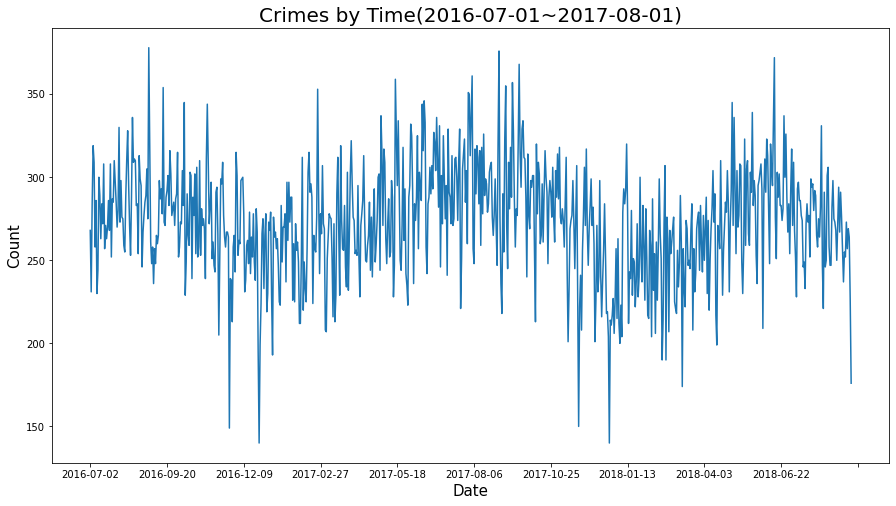

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time(2016-07-01~2017-08-01)",(15,8),80)

In [ ]:
def featureScaling(arr):
    scaler = MinMaxScaler(feature_range=(0, 1))
    result = scaler.fit_transform(arr)
    return result

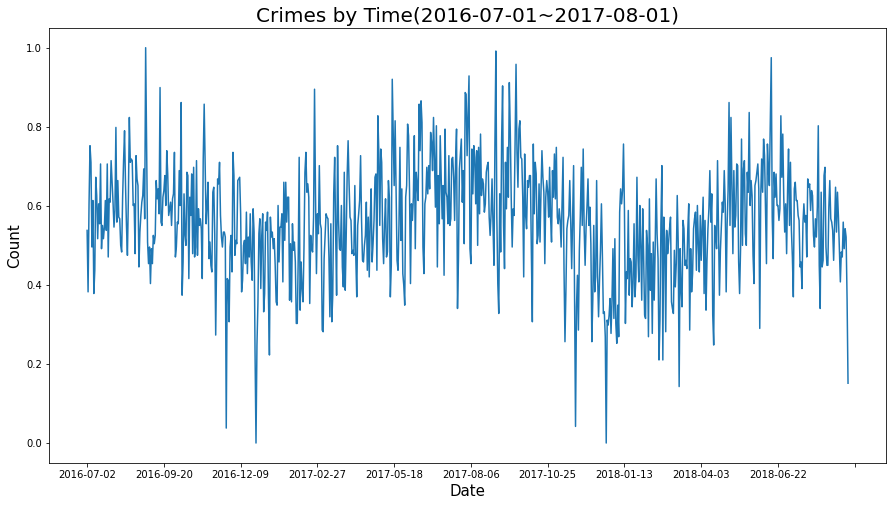

In [ ]:
t1["Count"]=featureScaling(t1["Count"].values.reshape(-1,1))
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time(2016-07-01~2017-08-01)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))

In [ ]:
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

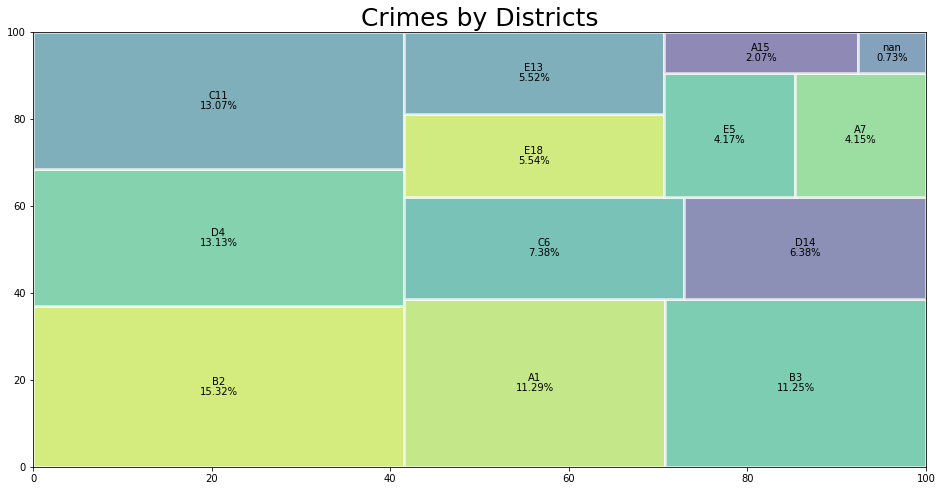

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

In [ ]:
Rawdata.Lat.replace(-1, None, inplace=True)
Rawdata.Long.replace(-1, None, inplace=True)

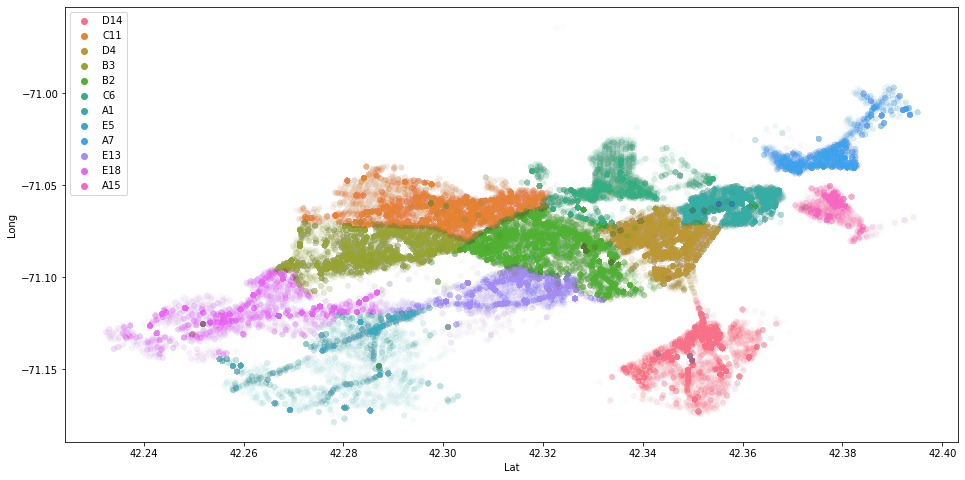

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.01,
               data=Rawdata)
plt.legend(loc=2)

# Crime wise SARIMAX Predictions and Analysis

### Accidents

In [ ]:
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

In [ ]:
accidents = Rawdata[Rawdata['OFFENSE_CODE_GROUP']=='Motor Vehicle Accident Response']
start_date = str((parse(max(accidents['OCCURRED_ON_DATE'])) - relativedelta(months = 12)).date())
start_date

'2017-09-03'

In [ ]:
target = accidents[accidents['DATE']>start_date]
target = target.sort_values(by="DATE",ascending = True)

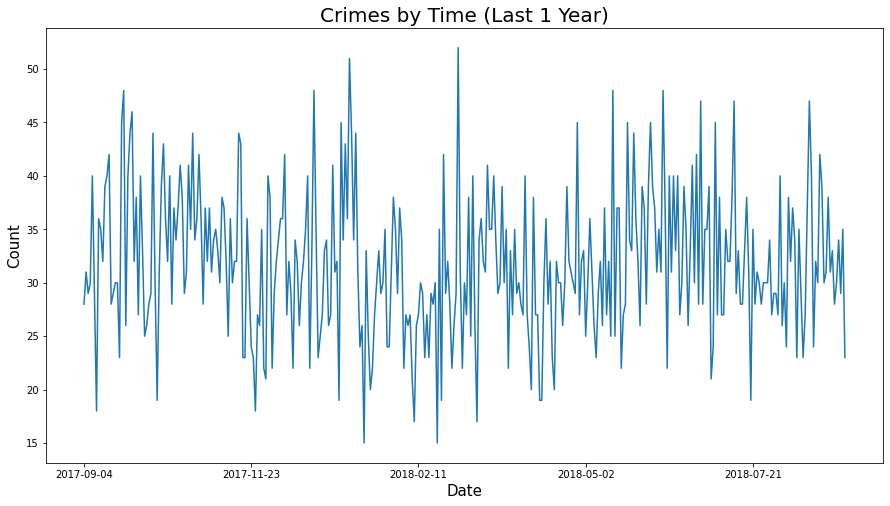

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time (Last 1 Year)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

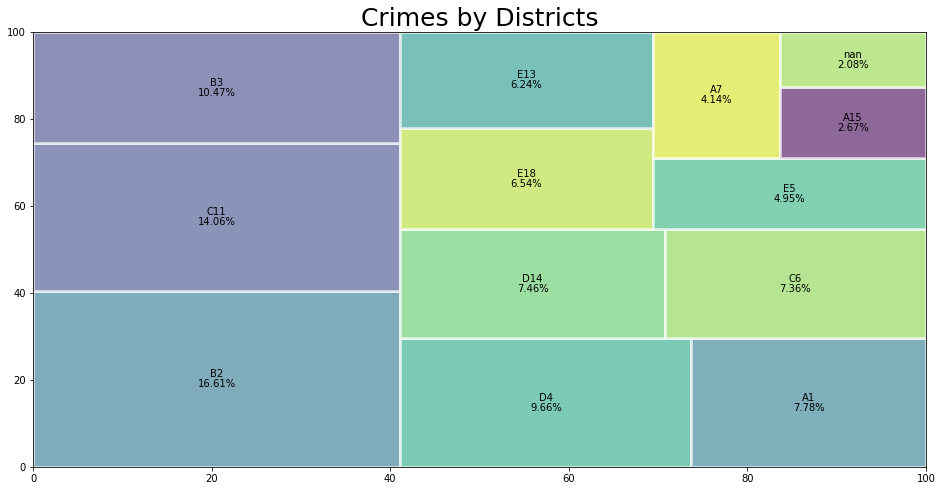

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

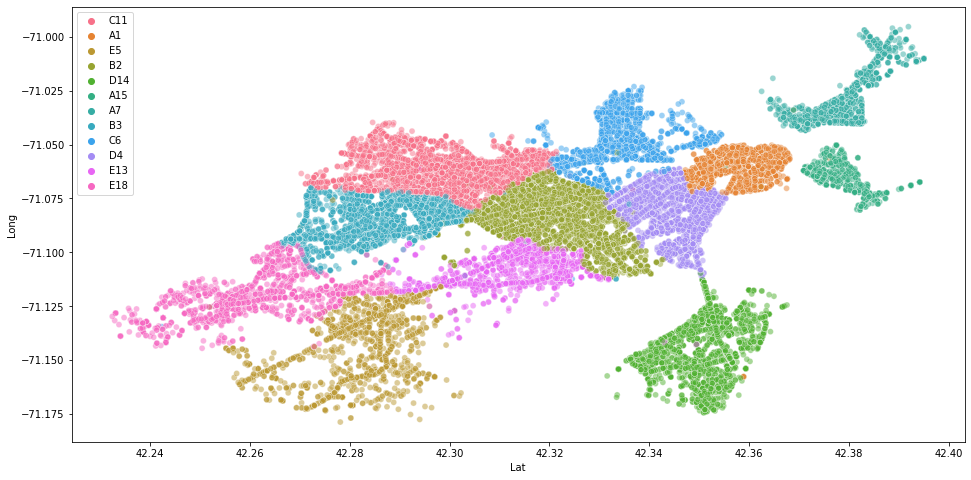

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.5,
               data=accidents)
plt.legend(loc=2)

In [ ]:
# Put Date and Count into a new Dataframe
c = createdf("Date",accidents["DATE"].value_counts().index,"Count",accidents["DATE"].value_counts())

c=c.sort_values(by="Date",ascending = True)

c

Date  Count
2015-06-15  2015-06-15     22
2015-06-16  2015-06-16     28
2015-06-17  2015-06-17     22
2015-06-18  2015-06-18     20
2015-06-19  2015-06-19     28
...                ...    ...
2018-08-30  2018-08-30     30
2018-08-31  2018-08-31     34
2018-09-01  2018-09-01     29
2018-09-02  2018-09-02     35
2018-09-03  2018-09-03     23

[1177 rows x 2 columns]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])
c = c.set_index('Date')
c = c.asfreq('D')
c

Count
Date             
2015-06-15     22
2015-06-16     28
2015-06-17     22
2015-06-18     20
2015-06-19     28
...           ...
2018-08-30     30
2018-08-31     34
2018-09-01     29
2018-09-02     35
2018-09-03     23

[1177 rows x 1 columns]

In [ ]:
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2015-06-15 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   1177 non-null   int64
dtypes: int64(1)
memory usage: 18.4 KB


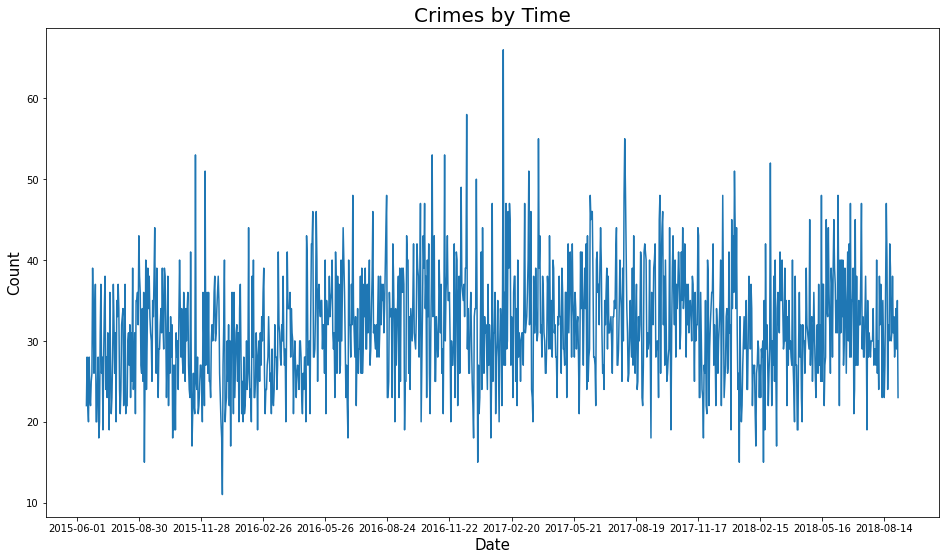

In [ ]:
lineplt(c.index,c["Count"],"Date","Count","Crimes by Time",(16,9),90)

In [ ]:
model=SARIMAX(c['Count'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 1177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3880.584
Date:                           Mon, 09 Jan 2023   AIC                           7771.167
Time:                                   00:36:30   BIC                           7796.487
Sample:                               06-15-2015   HQIC                          7780.717
                                    - 09-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1171      0.030      3.890      0.000       0.058       0.176
ma.L1         -0.9718      0.008   -124.982

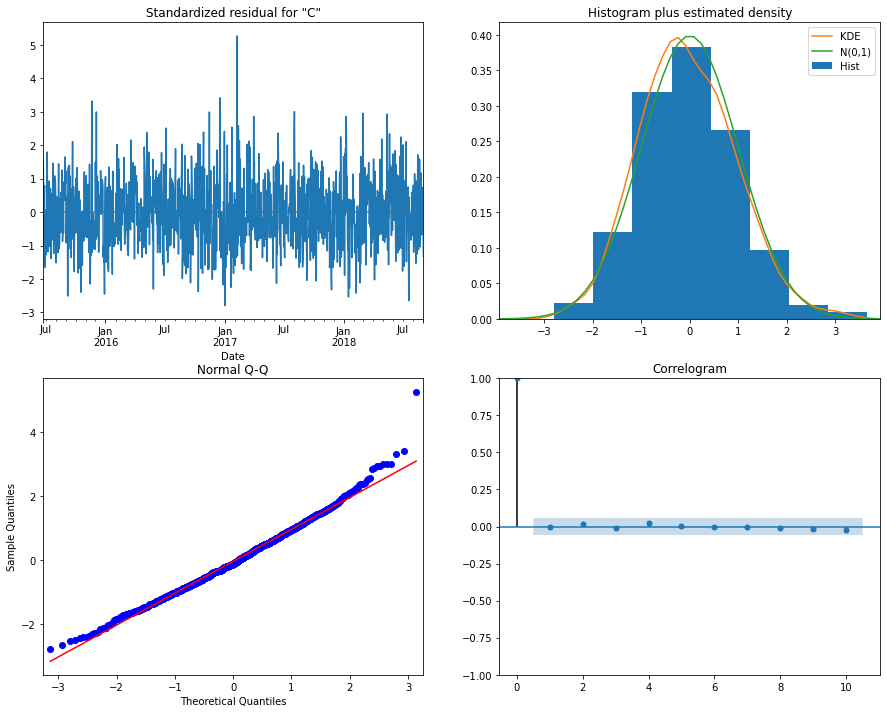

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Get forecast 30 steps ahead in future
pred_uc = model.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

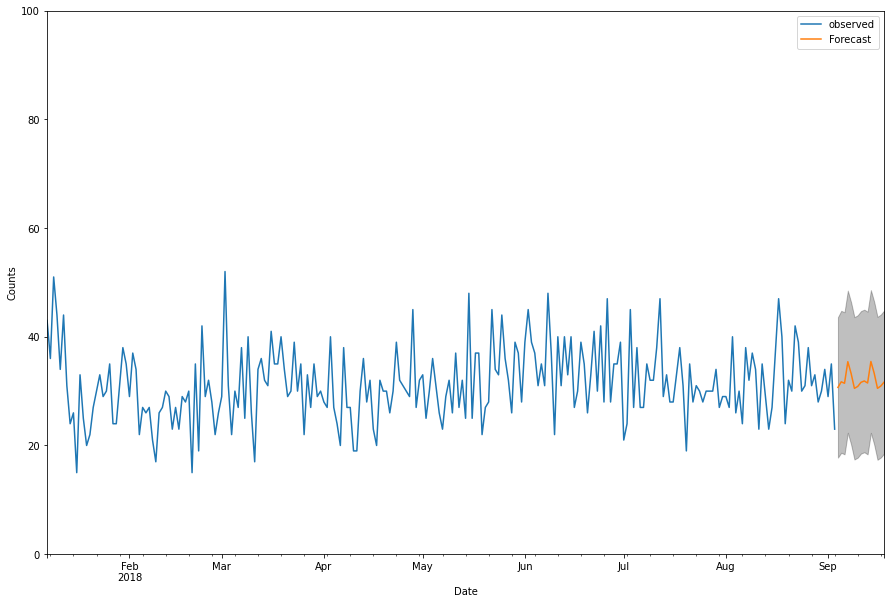

In [ ]:
ax = c['Count'][-240:].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

plt.ylim(0,100)
 
plt.legend()
plt.show()

In [ ]:
target = accidents[(accidents['DATE']>'2016-06-01') & (accidents['DATE']<'2017-08-01')]
target = target.sort_values(by="DATE",ascending = True)
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


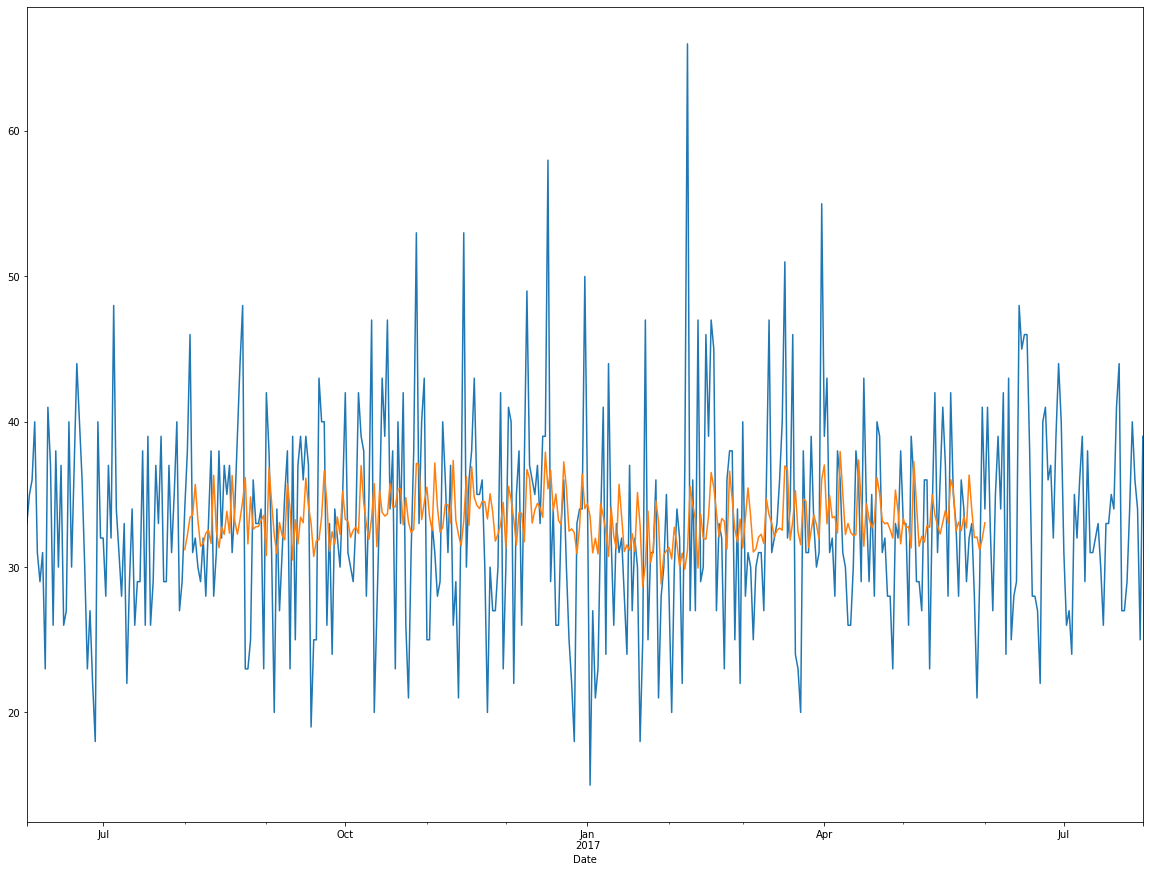

In [ ]:
timeseries = t1['Count']
predict_data = model.predict(start='2016-08-01', end='2017-06-01', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
temp = t1[(t1.index>='2016-08-01')&(t1.index<='2017-06-01')]
res = (np.array(temp['Count']))
mean_squared_error(res, predict_data, squared=False)

7.194676183248434

### Drugs

In [ ]:
drugs = Rawdata[Rawdata['OFFENSE_CODE_GROUP']=='Drug Violation']
start_date = str((parse(max(drugs['OCCURRED_ON_DATE'])) - relativedelta(months = 12)).date())
start_date

'2017-09-03'

In [ ]:
target = drugs[drugs['DATE']>start_date]
target = target.sort_values(by="DATE",ascending = True)

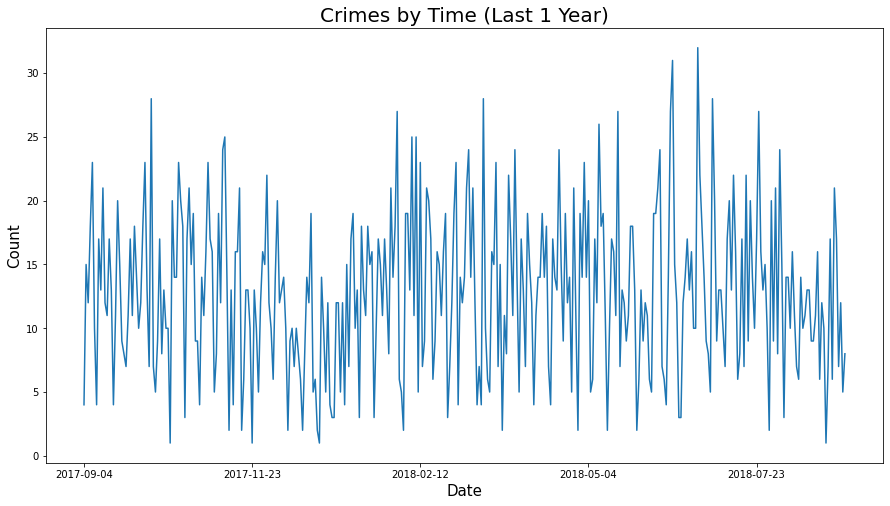

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time (Last 1 Year)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

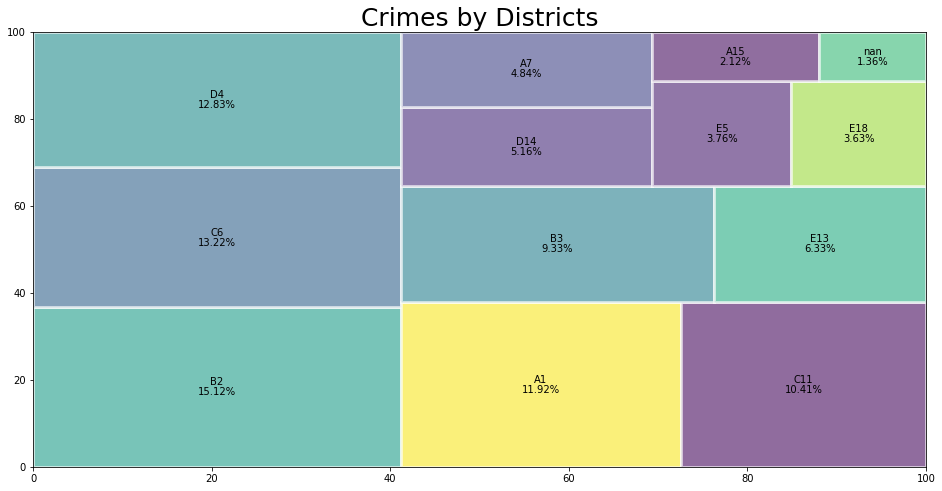

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

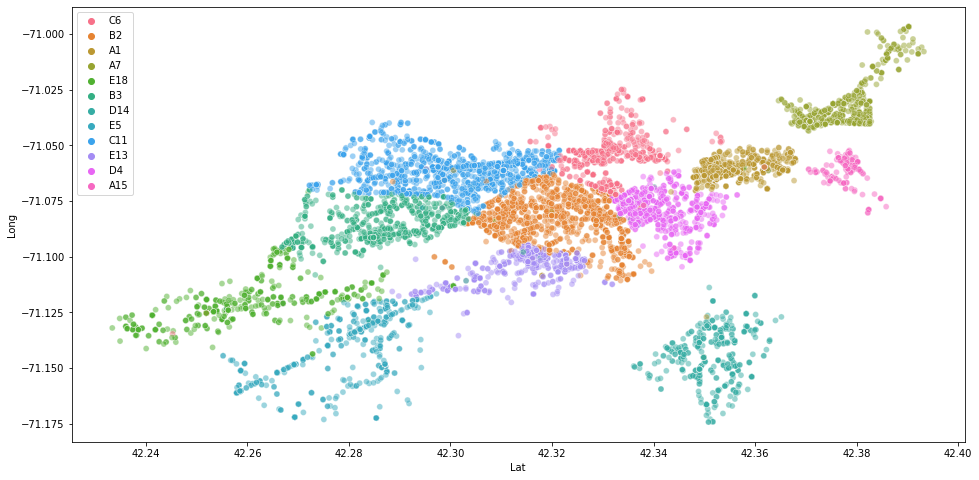

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.5,
               data=drugs)
plt.legend(loc=2)

In [ ]:
# Put Date and Count into a new Dataframe
c = createdf("Date",drugs["DATE"].value_counts().index,"Count",drugs["DATE"].value_counts())

c=c.sort_values(by="Date",ascending = True)

c

Date  Count
2015-06-15  2015-06-15     11
2015-06-16  2015-06-16     24
2015-06-17  2015-06-17      8
2015-06-18  2015-06-18      8
2015-06-19  2015-06-19     17
...                ...    ...
2018-08-30  2018-08-30     17
2018-08-31  2018-08-31      7
2018-09-01  2018-09-01     12
2018-09-02  2018-09-02      5
2018-09-03  2018-09-03      8

[1170 rows x 2 columns]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])
c = c.set_index('Date')
c = c.asfreq('D')
c

Count
Date             
2015-06-15   11.0
2015-06-16   24.0
2015-06-17    8.0
2015-06-18    8.0
2015-06-19   17.0
...           ...
2018-08-30   17.0
2018-08-31    7.0
2018-09-01   12.0
2018-09-02    5.0
2018-09-03    8.0

[1177 rows x 1 columns]

In [ ]:
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2015-06-15 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   1170 non-null   float64
dtypes: float64(1)
memory usage: 18.4 KB


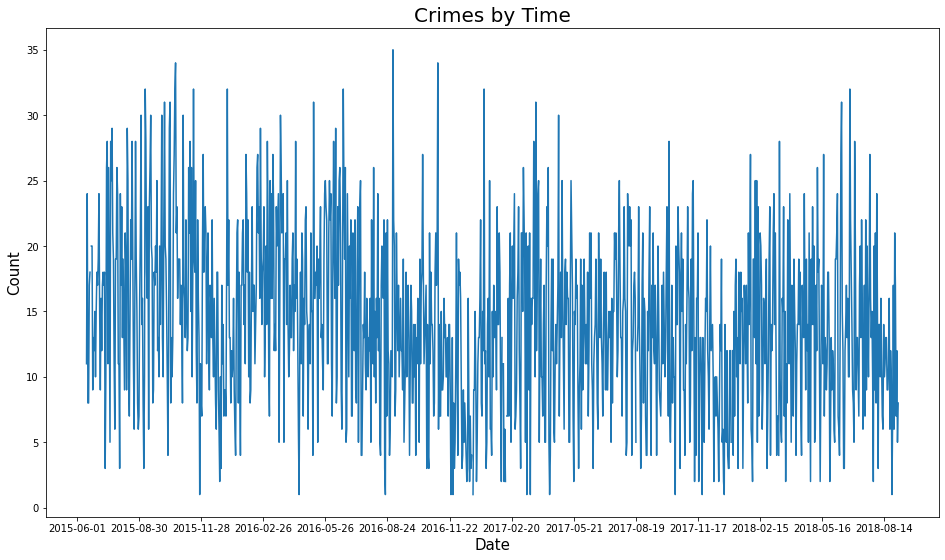

In [ ]:
lineplt(c.index,c["Count"],"Date","Count","Crimes by Time",(16,9),90)

In [ ]:
model=SARIMAX(c['Count'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 1177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3658.672
Date:                           Mon, 09 Jan 2023   AIC                           7327.344
Time:                                   00:36:38   BIC                           7352.663
Sample:                               06-15-2015   HQIC                          7336.894
                                    - 09-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0912      0.032      2.830      0.005       0.028       0.154
ma.L1         -0.9427      0.011    -83.042

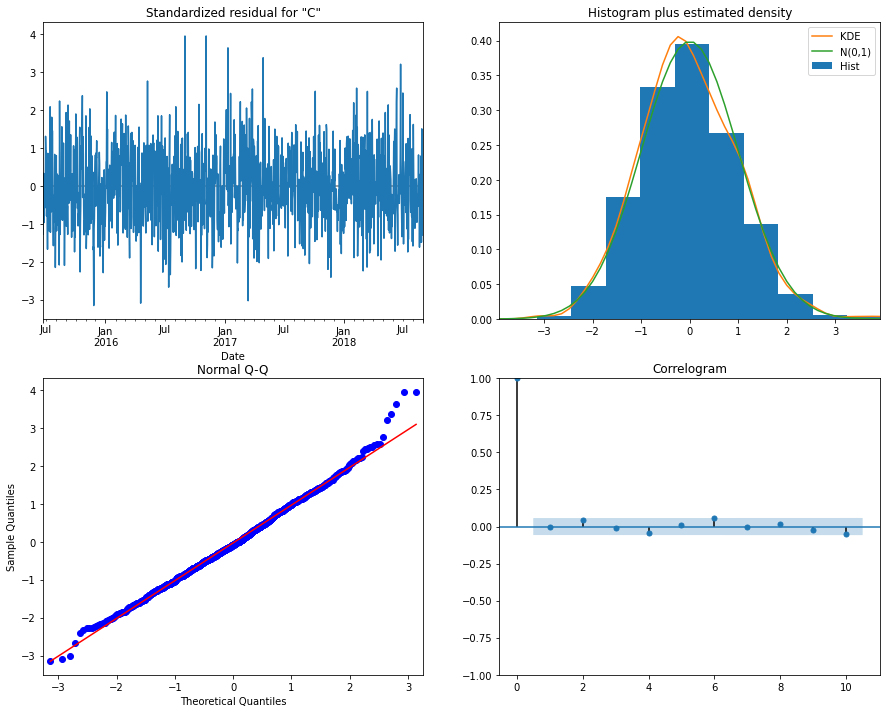

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Get forecast 30 steps ahead in future
pred_uc = model.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

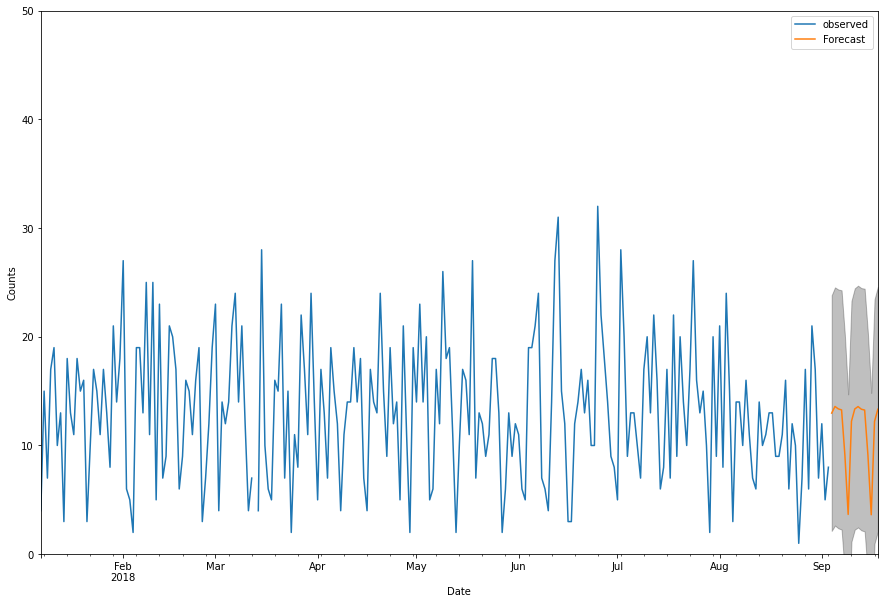

In [ ]:
ax = c['Count'][-240:].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

plt.ylim(0,50)
 
plt.legend()
plt.show()

In [ ]:
target = drugs[(drugs['DATE']>'2016-06-01') & (drugs['DATE']<'2017-08-01')]
target = target.sort_values(by="DATE",ascending = True)
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


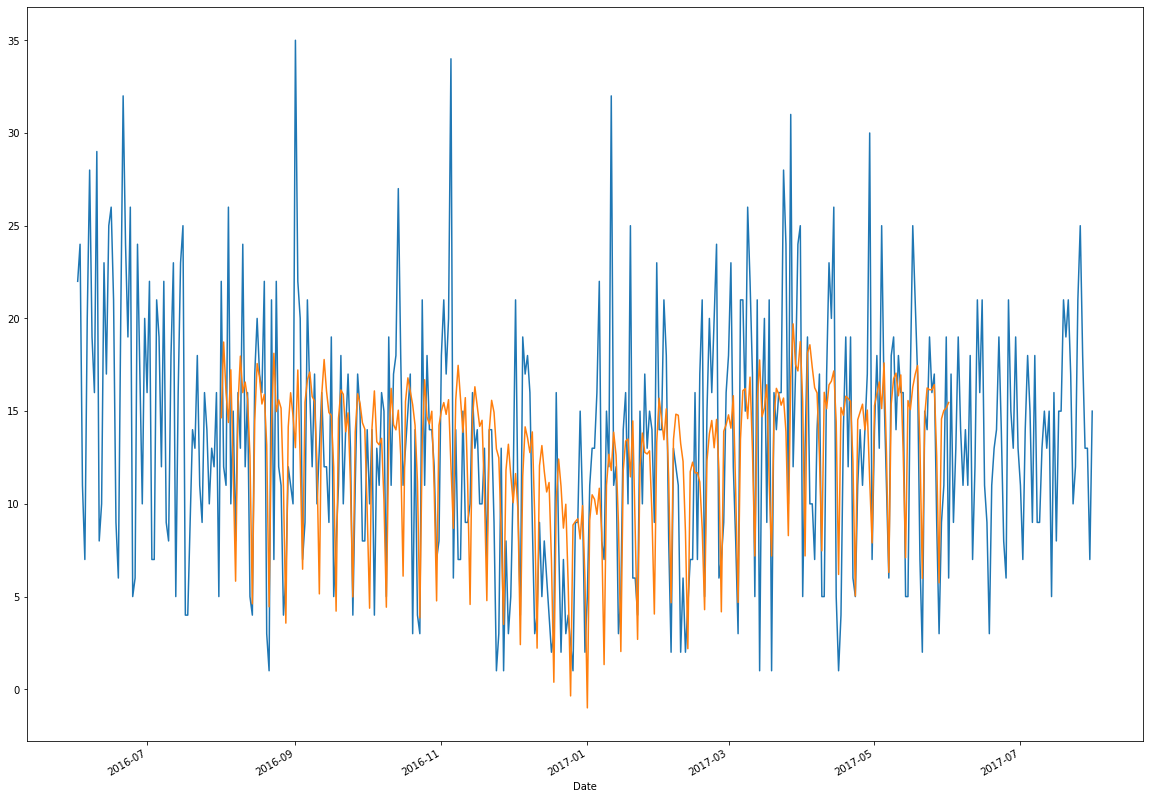

In [ ]:
timeseries = t1['Count']
predict_data = model.predict(start='2016-08-01', end='2017-06-01', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [ ]:
temp = t1[(t1.index>='2016-08-01')&(t1.index<='2017-06-01')]
temp.index = pd.to_datetime(temp.index)
missing = []
all = pd.date_range(start="2016-08-01", end="2017-06-01").difference(temp.index)
for i in all:
  missing.append(i)
missing

[Timestamp('2016-12-25 00:00:00'),
 Timestamp('2017-02-07 00:00:00'),
 Timestamp('2017-02-12 00:00:00')]

In [ ]:
for i in range(len(missing)):
  predict_data.drop(predict_data[predict_data.index == missing[i]].index, inplace=True)

len(predict_data)

302

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(np.array(temp['Count']), np.array(predict_data), squared=False)

5.905548900768877

### Violations

In [ ]:
violations = Rawdata[Rawdata['OFFENSE_CODE_GROUP']=='Violations']
start_date = str((parse(max(violations['OCCURRED_ON_DATE'])) - relativedelta(months = 12)).date())
start_date

'2017-09-03'

In [ ]:
target = violations[violations['DATE']>start_date]
target = target.sort_values(by="DATE",ascending = True)

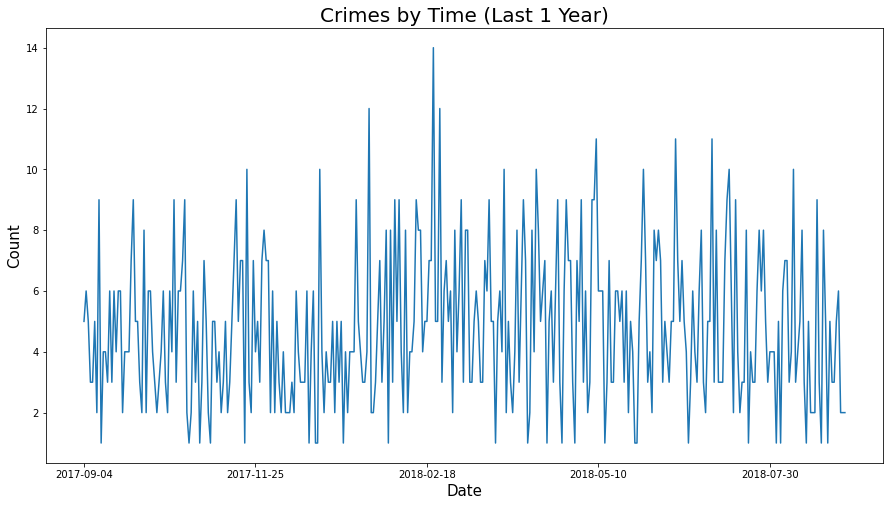

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time (Last 1 Year)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

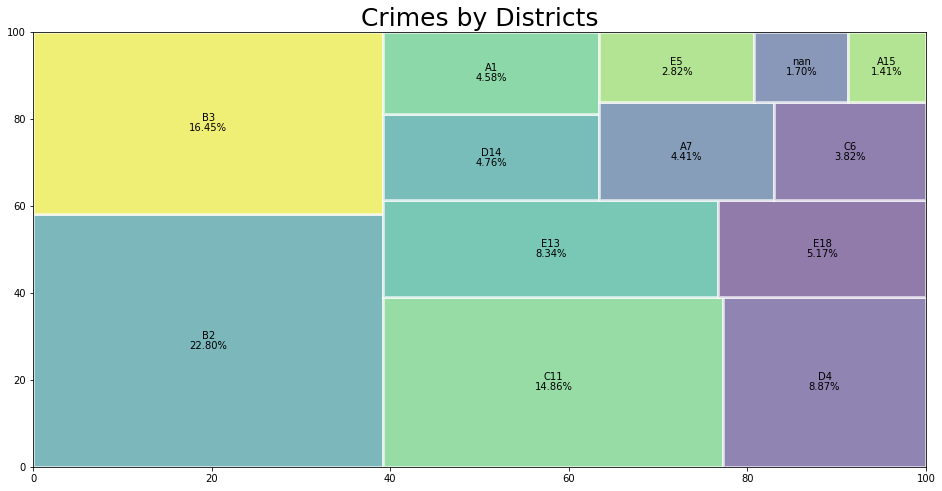

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

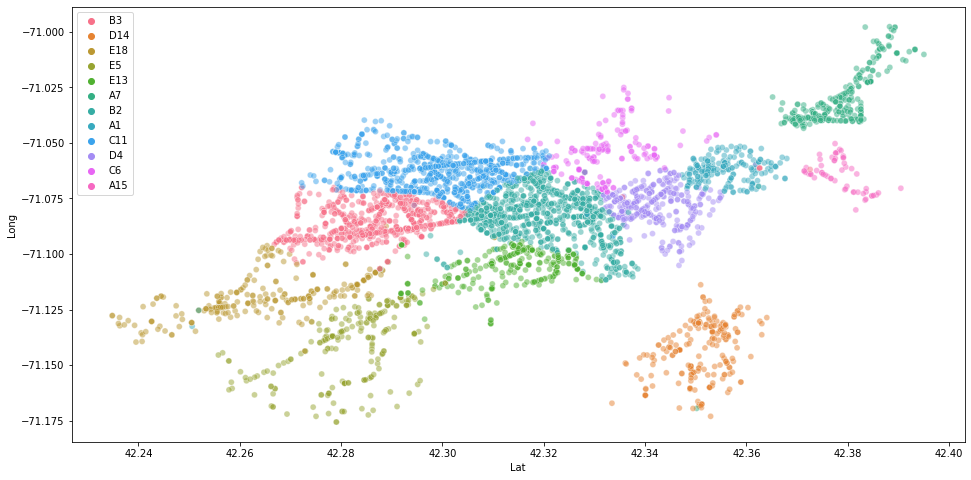

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.5,
               data=violations)
plt.legend(loc=2)

In [ ]:
# Put Date and Count into a new Dataframe
c = createdf("Date",violations["DATE"].value_counts().index,"Count",violations["DATE"].value_counts())

c=c.sort_values(by="Date",ascending = True)

c

Date  Count
2015-06-15  2015-06-15      4
2015-06-16  2015-06-16      7
2015-06-17  2015-06-17      5
2015-06-18  2015-06-18      6
2015-06-19  2015-06-19      5
...                ...    ...
2018-08-30  2018-08-30      5
2018-08-31  2018-08-31      6
2018-09-01  2018-09-01      2
2018-09-02  2018-09-02      2
2018-09-03  2018-09-03      2

[1158 rows x 2 columns]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])
c = c.set_index('Date')
c = c.asfreq('D')
c

Count
Date             
2015-06-15    4.0
2015-06-16    7.0
2015-06-17    5.0
2015-06-18    6.0
2015-06-19    5.0
...           ...
2018-08-30    5.0
2018-08-31    6.0
2018-09-01    2.0
2018-09-02    2.0
2018-09-03    2.0

[1177 rows x 1 columns]

In [ ]:
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2015-06-15 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   1158 non-null   float64
dtypes: float64(1)
memory usage: 18.4 KB


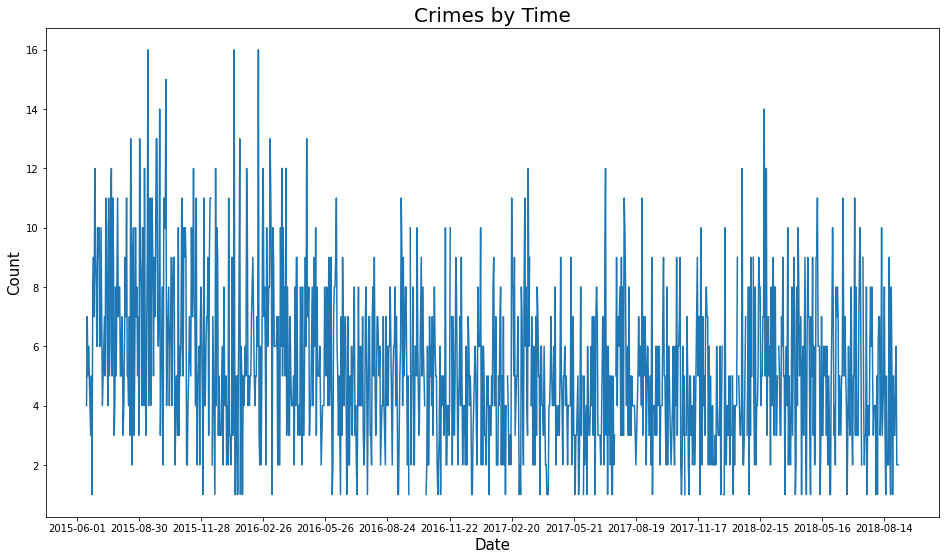

In [ ]:
lineplt(c.index,c["Count"],"Date","Count","Crimes by Time",(16,9),90)

In [ ]:
model=SARIMAX(c['Count'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 1177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2738.054
Date:                           Mon, 09 Jan 2023   AIC                           5486.107
Time:                                   00:36:46   BIC                           5511.427
Sample:                               06-15-2015   HQIC                          5495.657
                                    - 09-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0509      0.030      1.705      0.088      -0.008       0.109
ma.L1         -0.9758      0.008   -128.157

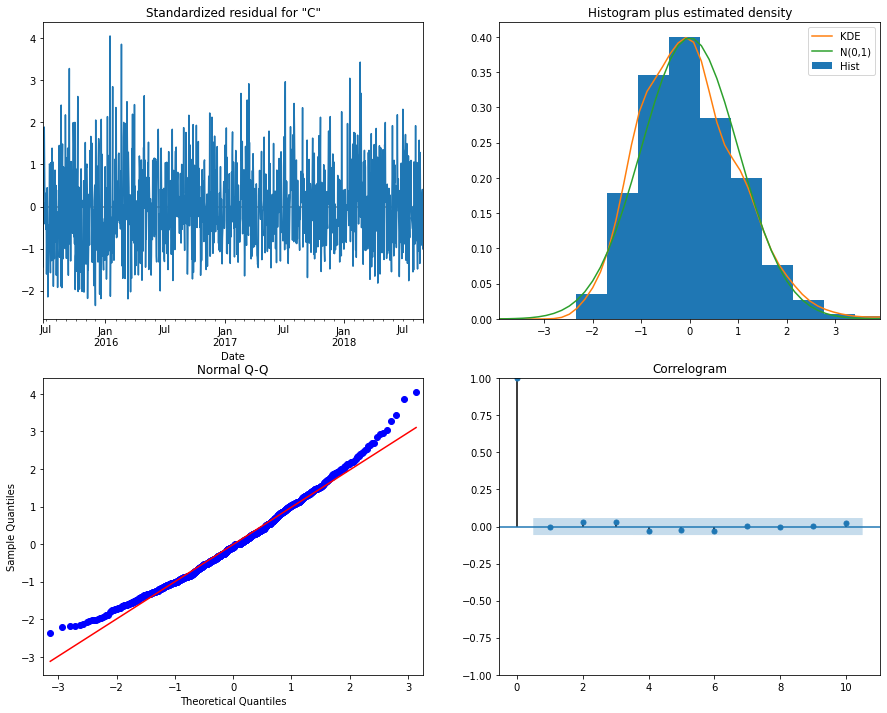

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Get forecast 30 steps ahead in future
pred_uc = model.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

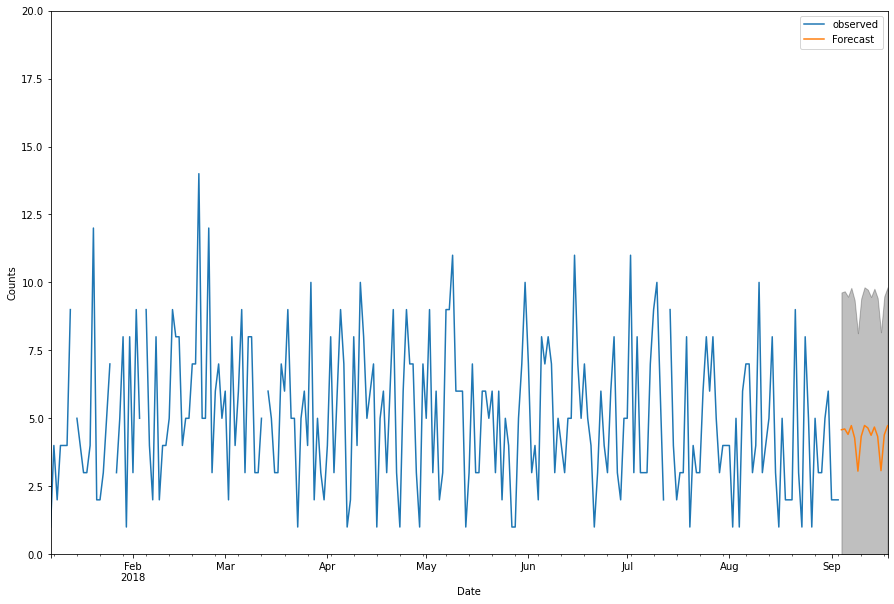

In [ ]:
ax = c['Count'][-240:].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

plt.ylim(0,20)
 
plt.legend()
plt.show()

In [ ]:
target = violations[(violations['DATE']>'2016-06-01') & (violations['DATE']<'2017-08-01')]
target = target.sort_values(by="DATE",ascending = True)
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


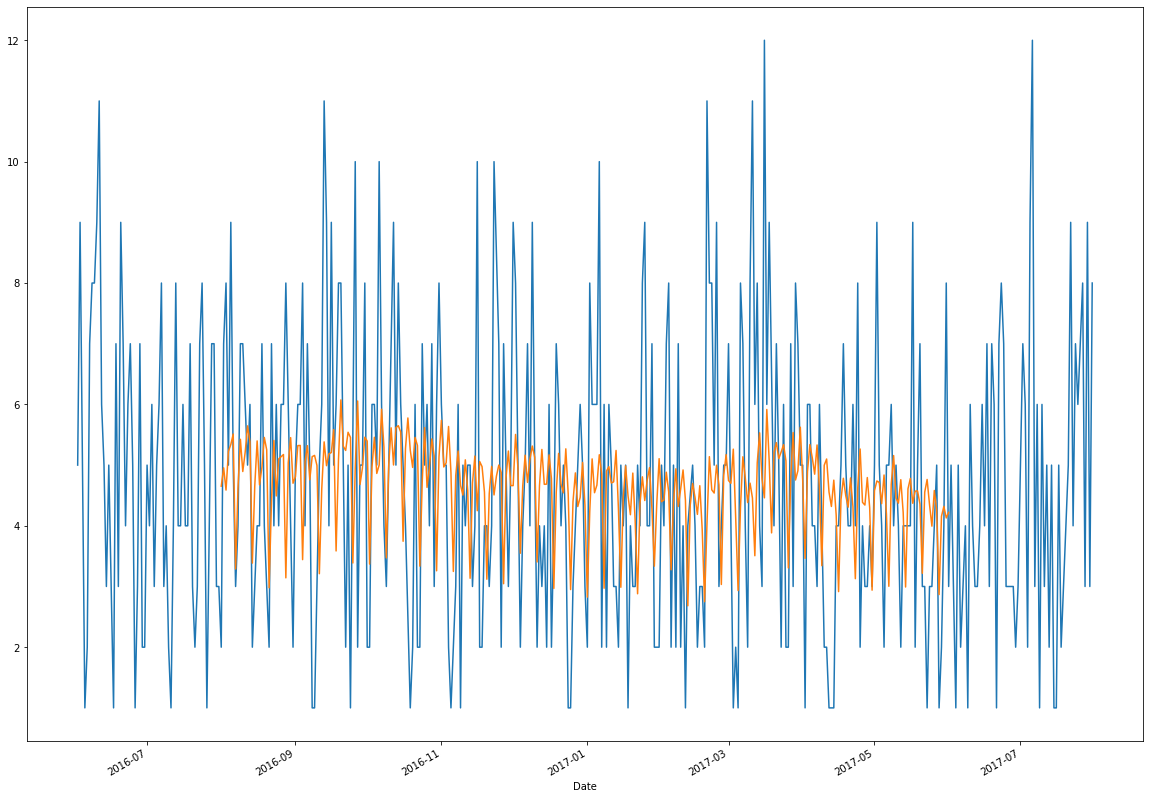

In [ ]:
timeseries = t1['Count']
predict_data = model.predict(start='2016-08-01', end='2017-06-01', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [ ]:
temp = t1[(t1.index>='2016-08-01')&(t1.index<='2017-06-01')]
temp.index = pd.to_datetime(temp.index)
missing = []
all = pd.date_range(start="2016-08-01", end="2017-06-01").difference(temp.index)
for i in all:
  missing.append(i)
missing

[Timestamp('2016-09-25 00:00:00'),
 Timestamp('2016-10-18 00:00:00'),
 Timestamp('2016-11-24 00:00:00'),
 Timestamp('2017-01-30 00:00:00'),
 Timestamp('2017-02-13 00:00:00'),
 Timestamp('2017-03-19 00:00:00')]

In [ ]:
for i in range(len(missing)):
  predict_data.drop(predict_data[predict_data.index == missing[i]].index, inplace=True)

len(predict_data)

299

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(np.array(temp['Count']), np.array(predict_data), squared=False)

2.290199406246004

### Assaults

In [ ]:
assaults = Rawdata[(Rawdata['OFFENSE_CODE_GROUP']=='Simple Assault') | (Rawdata['OFFENSE_CODE_GROUP']=='Aggravated Assault') ]
start_date = str((parse(max(assaults['OCCURRED_ON_DATE'])) - relativedelta(months = 12)).date())
start_date

'2017-09-03'

In [ ]:
target = assaults[assaults['DATE']>start_date]
target = target.sort_values(by="DATE",ascending = True)

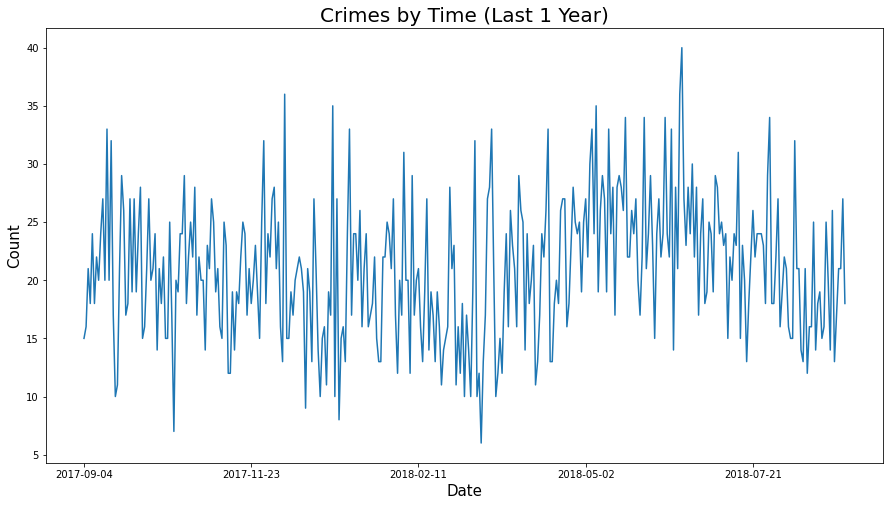

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time (Last 1 Year)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

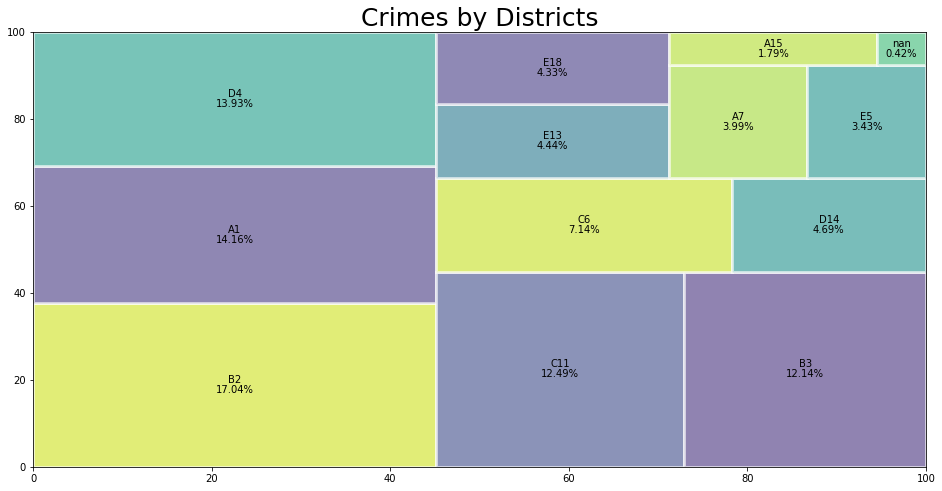

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

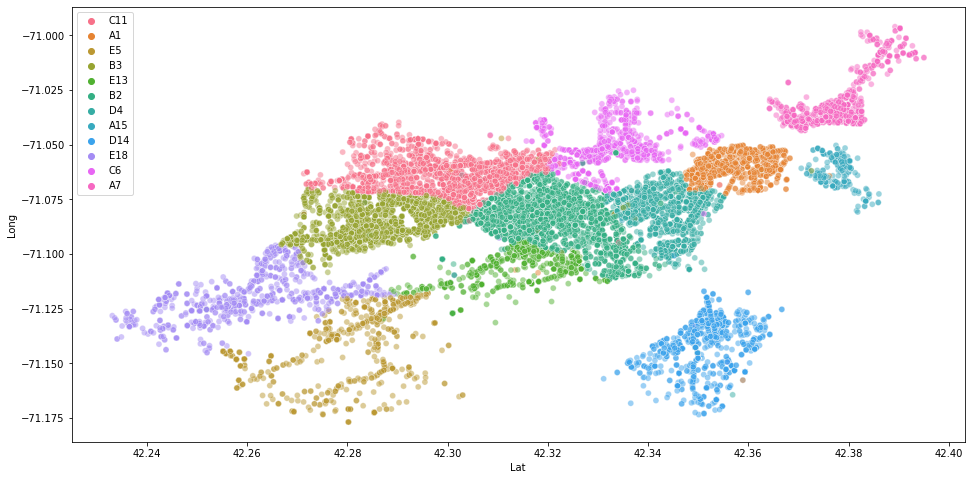

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.5,
               data=assaults)
plt.legend(loc=2)

In [ ]:
# Put Date and Count into a new Dataframe
c = createdf("Date",assaults["DATE"].value_counts().index,"Count",assaults["DATE"].value_counts())

c=c.sort_values(by="Date",ascending = True)

c

Date  Count
2015-06-15  2015-06-15     21
2015-06-16  2015-06-16     22
2015-06-17  2015-06-17     17
2015-06-18  2015-06-18     19
2015-06-19  2015-06-19     24
...                ...    ...
2018-08-30  2018-08-30     17
2018-08-31  2018-08-31     21
2018-09-01  2018-09-01     21
2018-09-02  2018-09-02     27
2018-09-03  2018-09-03     18

[1177 rows x 2 columns]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])
c = c.set_index('Date')
c = c.asfreq('D')
c

Count
Date             
2015-06-15     21
2015-06-16     22
2015-06-17     17
2015-06-18     19
2015-06-19     24
...           ...
2018-08-30     17
2018-08-31     21
2018-09-01     21
2018-09-02     27
2018-09-03     18

[1177 rows x 1 columns]

In [ ]:
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2015-06-15 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   1177 non-null   int64
dtypes: int64(1)
memory usage: 18.4 KB


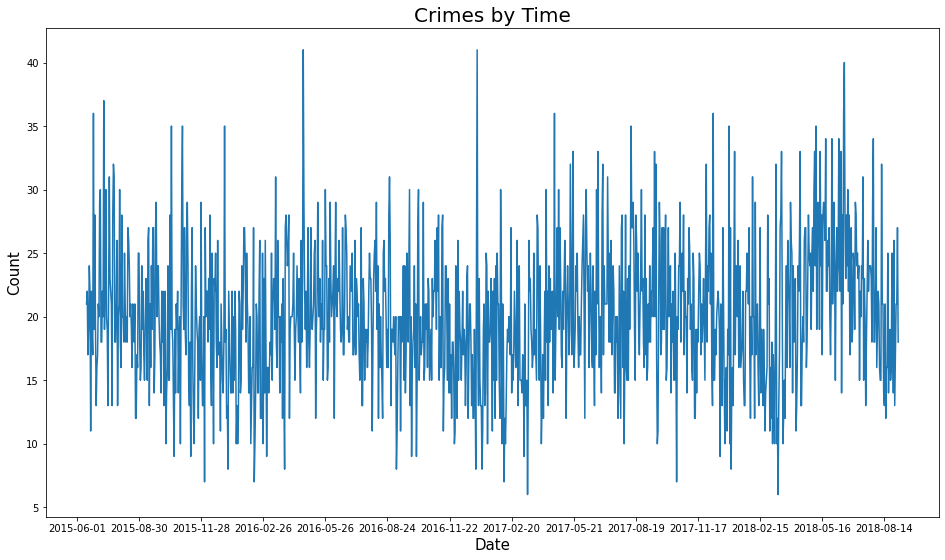

In [ ]:
lineplt(c.index,c["Count"],"Date","Count","Crimes by Time",(16,9),90)

In [ ]:
model=SARIMAX(c['Count'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 1177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3597.738
Date:                           Mon, 09 Jan 2023   AIC                           7205.477
Time:                                   00:36:55   BIC                           7230.796
Sample:                               06-15-2015   HQIC                          7215.027
                                    - 09-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0426      0.030      1.410      0.159      -0.017       0.102
ma.L1         -0.9451      0.011    -88.939

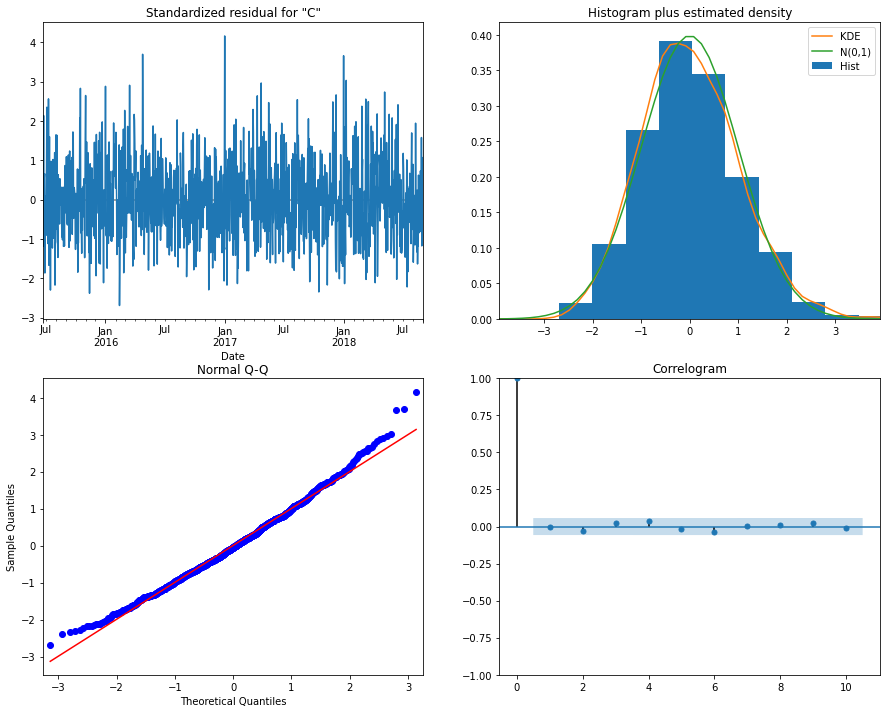

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Get forecast 30 steps ahead in future
pred_uc = model.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

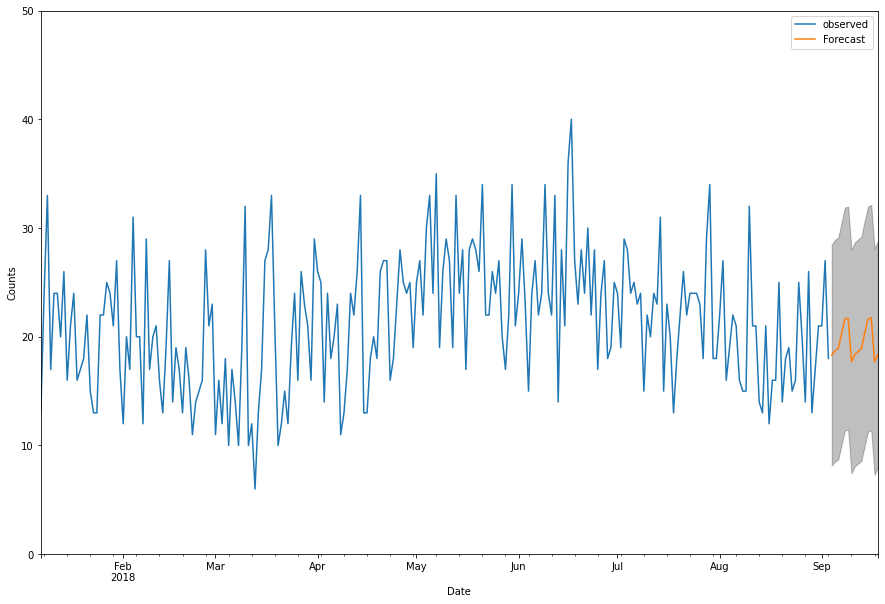

In [ ]:
ax = c['Count'][-240:].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

plt.ylim(0,50)
 
plt.legend()
plt.show()

In [ ]:
target = assaults[(assaults['DATE']>'2016-06-01') & (assaults['DATE']<'2017-08-01')]
target = target.sort_values(by="DATE",ascending = True)
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


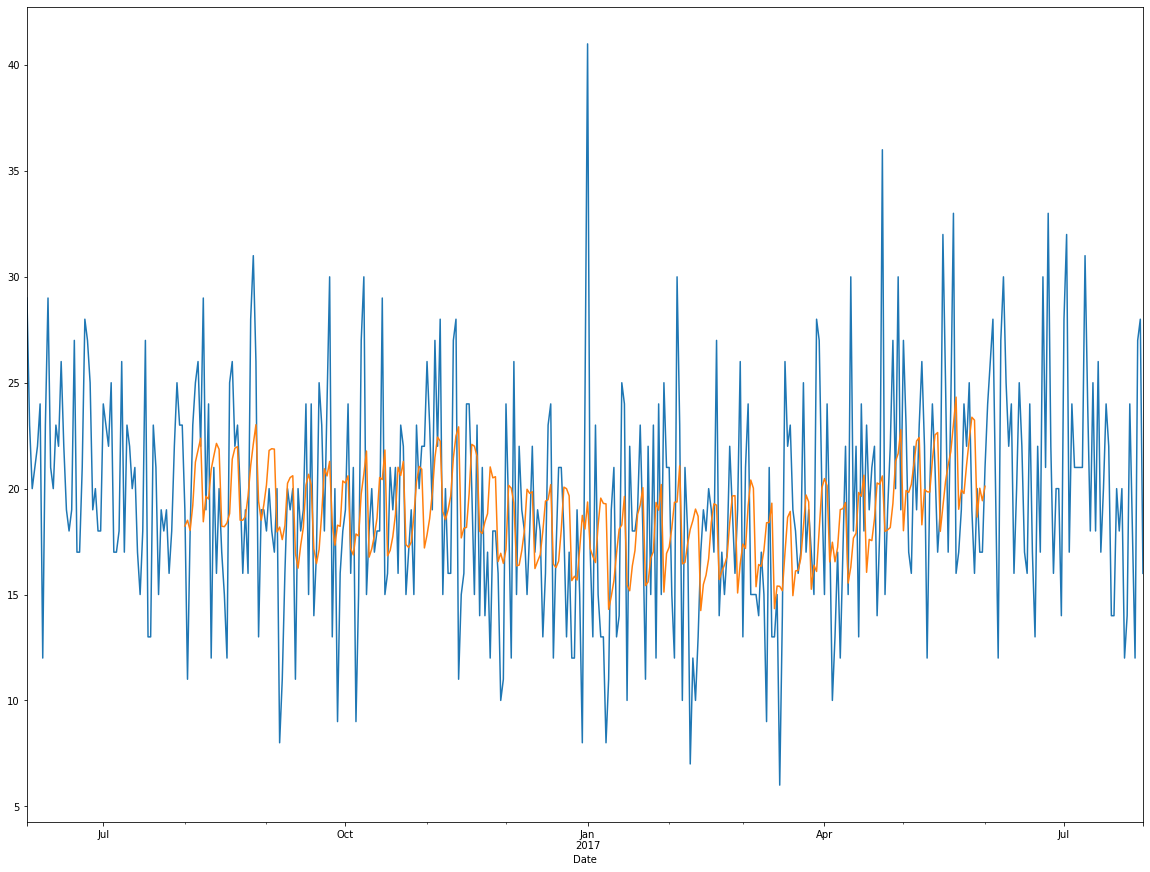

In [ ]:
timeseries = t1['Count']
predict_data = model.predict(start='2016-08-01', end='2017-06-01', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
temp = t1[(t1.index>='2016-08-01')&(t1.index<='2017-06-01')]
res = (np.array(temp['Count']))
mean_squared_error(res, predict_data, squared=False)

5.059604577294598

### Larceny

In [ ]:
larceny = Rawdata[(Rawdata['OFFENSE_CODE_GROUP']=='Larceny')]
start_date = str((parse(max(larceny['OCCURRED_ON_DATE'])) - relativedelta(months = 12)).date())
start_date

'2017-09-03'

In [ ]:
target = larceny[larceny['DATE']>start_date]
target = target.sort_values(by="DATE",ascending = True)

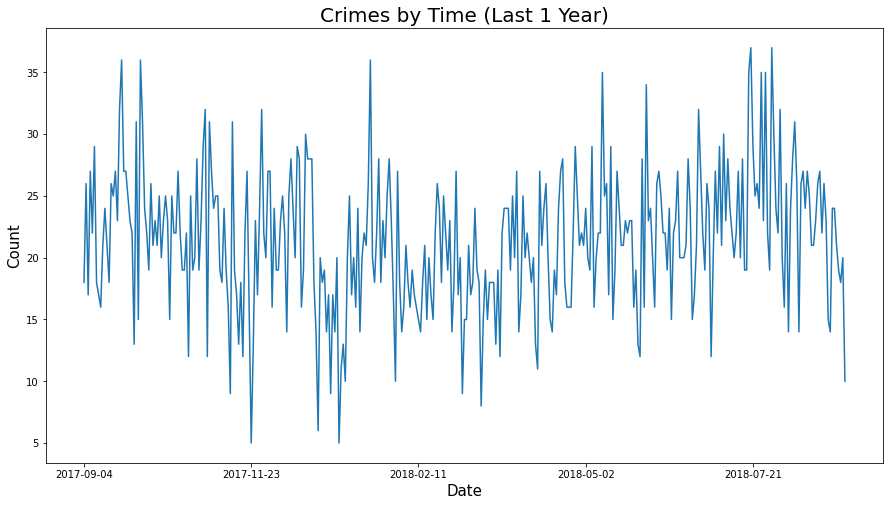

In [ ]:
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)
lineplt(t1["Date"],t1["Count"],"Date","Count","Crimes by Time (Last 1 Year)",(15,8),80)

In [ ]:
t2 = createdf("District",target['DISTRICT'].value_counts(dropna=False).index,"Count",target['DISTRICT'].value_counts(dropna=False))
t2["Count"].sum()
t2['Percent'] = t2["Count"]/t2["Count"].sum()

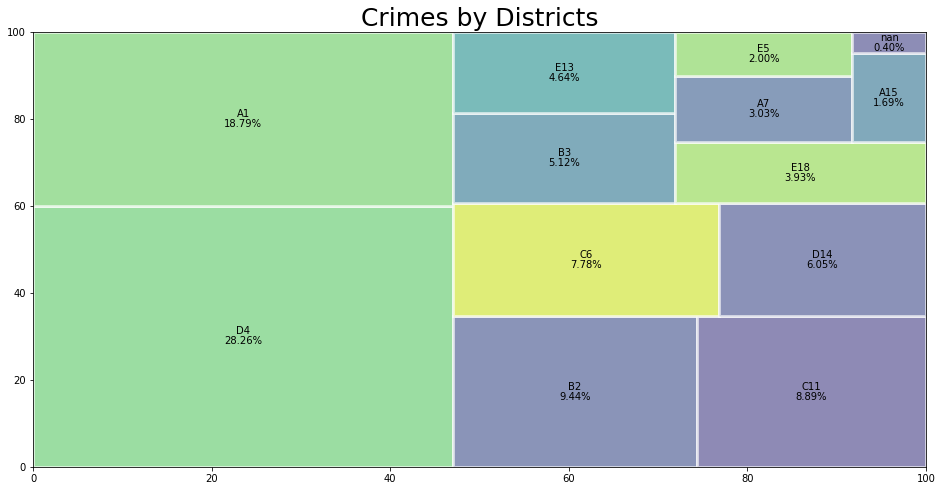

In [ ]:
fig = plt.figure(figsize=(16,8))
plot = squarify.plot(sizes = t2["Percent"],
                     label = t2["District"],
                     alpha = 0.6,
                     value = t2["Percent"].apply(lambda x: format(x, '.2%')) ,
                     edgecolor = 'white',
                     linewidth =3
                    )
plot.set_title('Crimes by Districts',fontdict = {'fontsize':25})
plt.show()

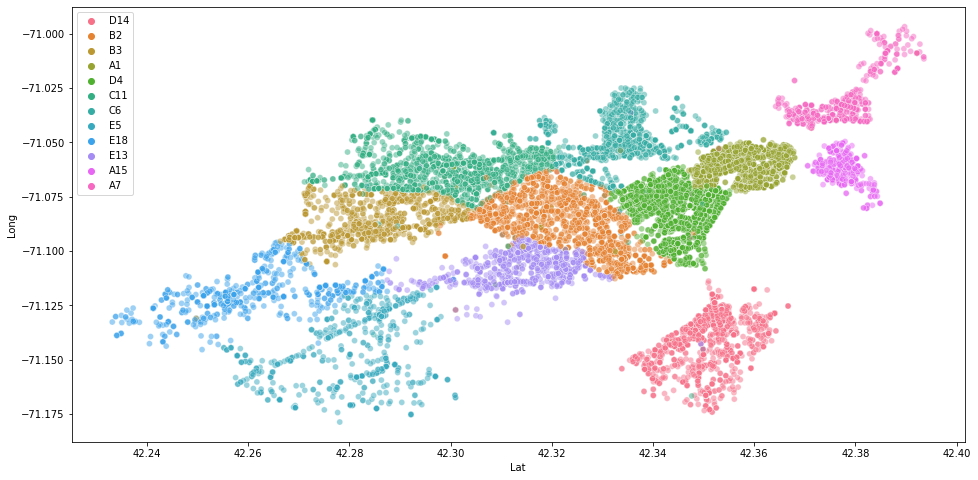

In [ ]:
fig = plt.figure(figsize=(16,8))
sns.scatterplot(x='Lat',
               y='Long',
                hue='DISTRICT',
                alpha=0.5,
               data=larceny)
plt.legend(loc=2)

In [ ]:
# Put Date and Count into a new Dataframe
c = createdf("Date",larceny["DATE"].value_counts().index,"Count",larceny["DATE"].value_counts())

c=c.sort_values(by="Date",ascending = True)

c

Date  Count
2015-06-15  2015-06-15     28
2015-06-16  2015-06-16     24
2015-06-17  2015-06-17     33
2015-06-18  2015-06-18     25
2015-06-19  2015-06-19     34
...                ...    ...
2018-08-30  2018-08-30     21
2018-08-31  2018-08-31     19
2018-09-01  2018-09-01     18
2018-09-02  2018-09-02     20
2018-09-03  2018-09-03     10

[1177 rows x 2 columns]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])
c = c.set_index('Date')
c = c.asfreq('D')
c

Count
Date             
2015-06-15     28
2015-06-16     24
2015-06-17     33
2015-06-18     25
2015-06-19     34
...           ...
2018-08-30     21
2018-08-31     19
2018-09-01     18
2018-09-02     20
2018-09-03     10

[1177 rows x 1 columns]

In [ ]:
c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2015-06-15 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   1177 non-null   int64
dtypes: int64(1)
memory usage: 18.4 KB


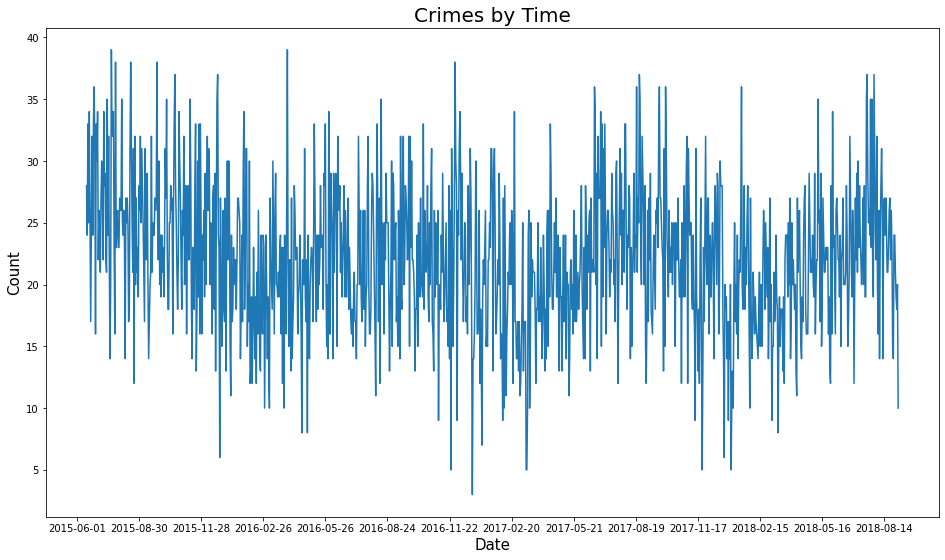

In [ ]:
lineplt(c.index,c["Count"],"Date","Count","Crimes by Time",(16,9),90)

In [ ]:
model=SARIMAX(c['Count'], order=(1,1,1), seasonal_order=(1,1,1, 7)).fit()
summary = model.summary()
print(summary)

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 1177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3657.393
Date:                           Mon, 09 Jan 2023   AIC                           7324.787
Time:                                   00:37:03   BIC                           7350.106
Sample:                               06-15-2015   HQIC                          7334.337
                                    - 09-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0640      0.029      2.194      0.028       0.007       0.121
ma.L1         -0.9466      0.011    -89.780

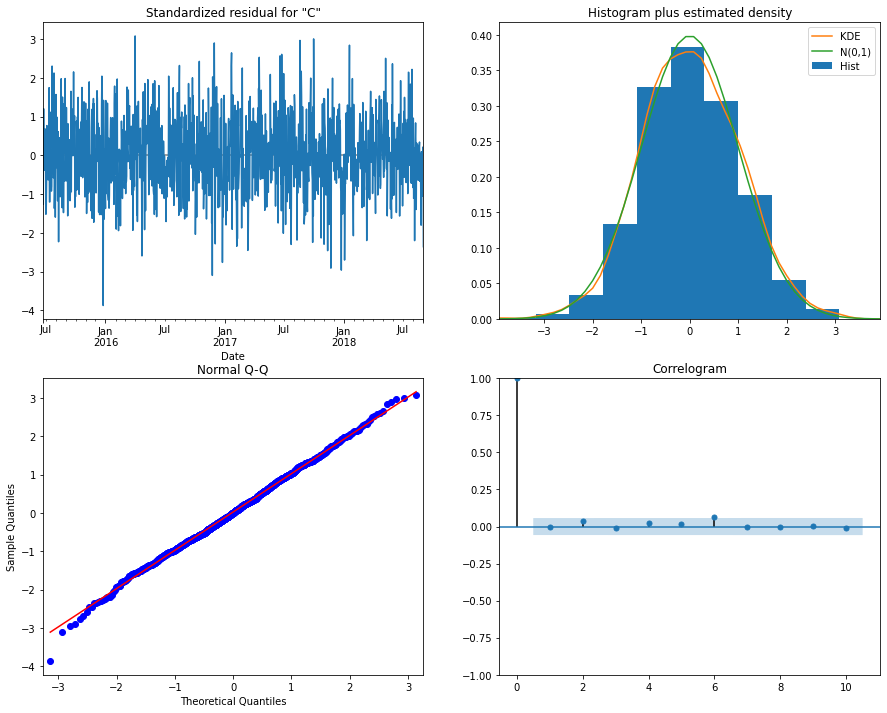

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Get forecast 30 steps ahead in future
pred_uc = model.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

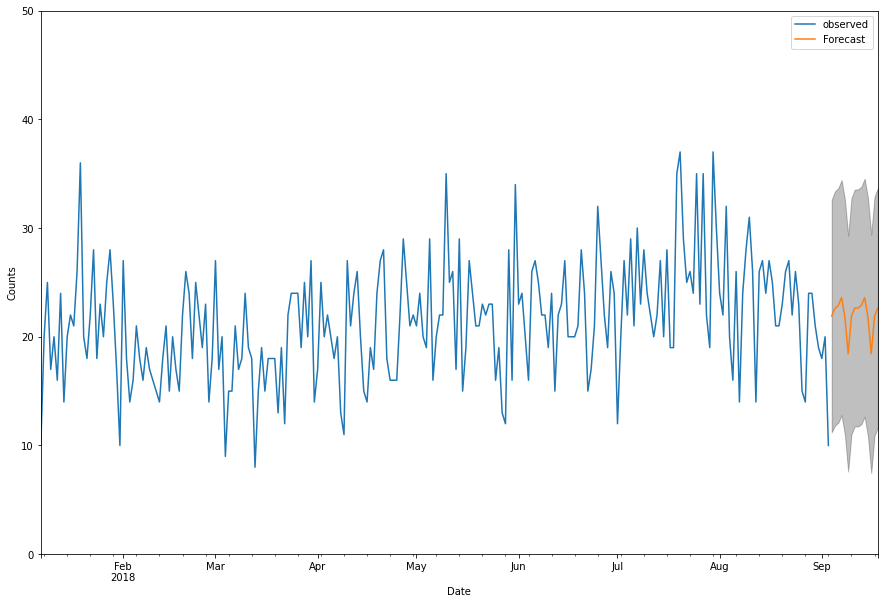

In [ ]:
ax = c['Count'][-240:].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

plt.ylim(0,50)
 
plt.legend()
plt.show()

In [ ]:
target = larceny[(larceny['DATE']>'2016-06-01') & (larceny['DATE']<'2017-08-01')]
target = target.sort_values(by="DATE",ascending = True)
t1 = createdf("Date",target["DATE"].value_counts().index,"Count",target["DATE"].value_counts())
t1 = t1.sort_values(by="Date",ascending = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


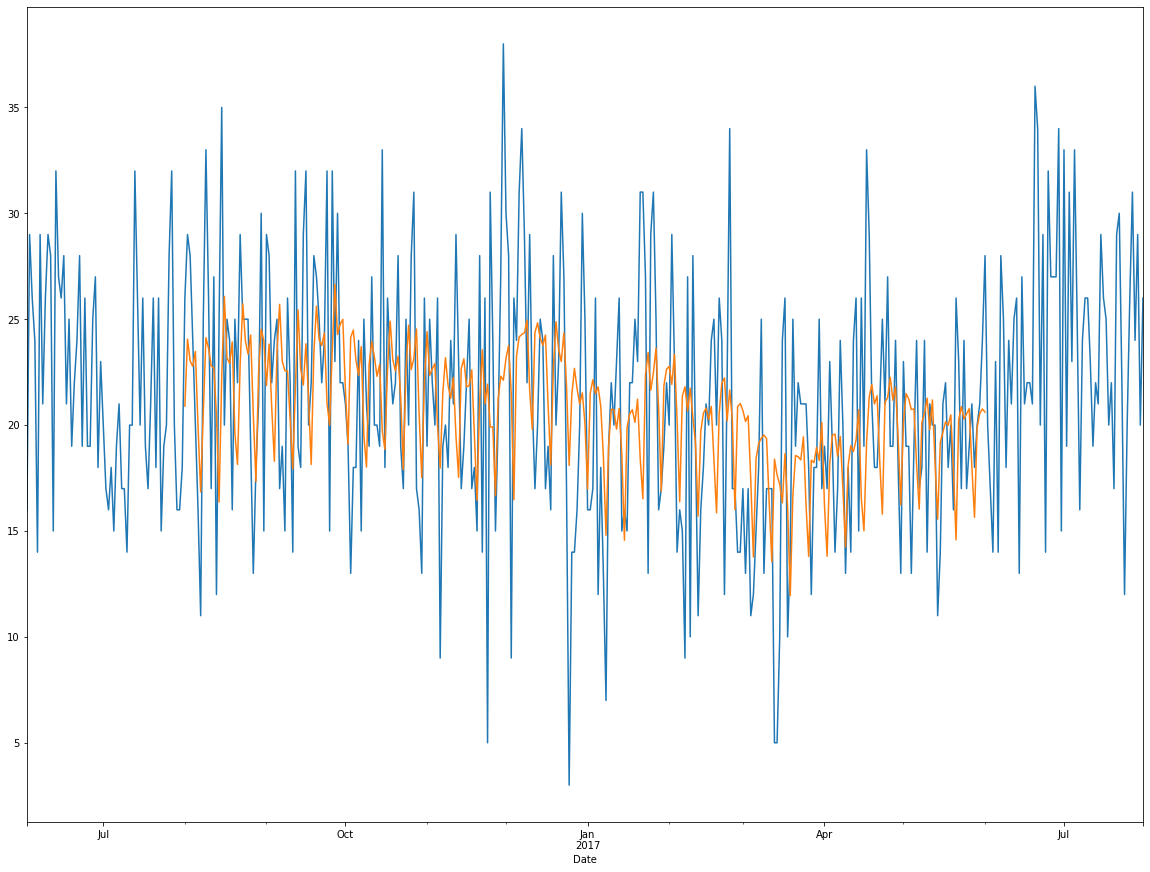

In [ ]:
timeseries = t1['Count']
predict_data = model.predict(start='2016-08-01', end='2017-06-01', dynamic = False)
timeseries.index = pd.DatetimeIndex(timeseries.index)
fig, ax = plt.subplots(figsize=(20, 15))
ax = timeseries.plot(ax=ax)
predict_data.plot(ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
temp = t1[(t1.index>='2016-08-01')&(t1.index<='2017-06-01')]
res = (np.array(temp['Count']))
mean_squared_error(res, predict_data, squared=False)

5.632957753424848